# Tendencies of Housing Prices in NYC

The goal of this project is to highlight pricing tendencies depending on a range of factors with the help of Multiple Linear Regression Model and visualise results using 2D and 3D graphs. 

The data on one-bedroom apartments in three of the five New York City boroughs: Brooklyn, Manhattan, and Queens is collected by codecademy from Streeteasy.com. Considering that "Streeteasy" is only used by a subset of property owners we can not assume that these prices are representative for the entire borough, but hopefully it will give us understanding of at least some trends in NYC apartment market. 

### Data Investigation & Cleaning
First we import libraries and upload csv files to variables for further work. 

In [1]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports for visualisation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Imports for ml
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

brooklyn = pd.read_csv('brooklyn-one-bed.csv')
manhattan = pd.read_csv('manhattan-one-bed.csv')
queens = pd.read_csv('queens-one-bed.csv')

Let's see what these files contain. 

In [2]:
# Display all columns
pd.set_option('display.max_columns', None)
brooklyn.head(3)

,rental_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,borough
0,2869,3600,3.0,2,900,4,1.0,15,1,0,0,0,0,0,0,0,Williamsburg,Brooklyn
1,4318,3900,3.0,2,1000,4,9.0,8,0,0,0,0,1,0,0,0,Greenwood,Brooklyn
2,6265,2700,2.0,1,900,4,2.0,96,0,0,0,0,0,0,0,0,Gowanus,Brooklyn


In [3]:
manhattan.head(3)

,rental_id,rental_id.1,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,submarket,borough
0,3,2919,76909719,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,All Midtown,Manhattan
1,4,2790,92953520,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,All Downtown,Manhattan
2,15,1437,66221183,4650,1.0,1,915,5,5.0,106,0,0,0,0,0,0,0,0,Upper East Side,All Upper East Side,Manhattan


In [4]:
queens.head(3)

,rental_id,rental_id.1,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,submarket,borough
0,6,10524,60898078,1950,1.0,1,950,1,3.0,83,0,0,0,0,0,0,0,0,Forest Hills,Central Queens,Queens
1,8,5465,73060494,3500,1.0,1,996,9,7.0,3,1,0,0,0,0,0,0,0,Astoria,Northwest Queens,Queens
2,21,5259,2540088,1725,1.0,1,800,1,2.0,89,0,0,0,0,0,0,0,0,Astoria,Northwest Queens,Queens


Considering that we are going to use this data to feed the ml algo we need it to be in one `df`. So we are going to concatenate 3 `df`s to one big, truncating some unnecessary fields in the process. 

In [5]:
def concatenate(datasets):
    columns = [
        'borough',
        'rent',
        'bedrooms',
        'bathrooms',
        'size_sqft',
        'min_to_subway', 
        'floor', 
        'building_age_yrs', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher',
        'has_patio',
        'has_doorman', 
        'has_gym', 
        'neighborhood'        
        ]
    return pd.concat([dataset[columns] for dataset in datasets]).reset_index(drop=True)

nyc_flats = concatenate([manhattan, queens, brooklyn])
nyc_flats.head(3)

,borough,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,has_roofdeck,has_elevator,has_dishwasher,has_patio,has_doorman,has_gym,neighborhood
0,Manhattan,4500,1.0,1,916,2,51.0,29,1,1,1,0,1,0,Midtown
1,Manhattan,4795,1.0,1,975,3,8.0,31,0,1,1,0,1,1,Greenwich Village
2,Manhattan,4650,1.0,1,915,5,5.0,106,0,0,0,0,0,0,Upper East Side


In [6]:
nyc_flats.tail(3)

,borough,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,has_roofdeck,has_elevator,has_dishwasher,has_patio,has_doorman,has_gym,neighborhood
2718,Brooklyn,4000,2.0,1,1080,5,1.0,117,0,0,0,0,0,0,Williamsburg
2719,Brooklyn,4200,2.0,2,977,1,5.0,5,0,0,0,0,0,0,Downtown Brooklyn
2720,Brooklyn,18000,3.0,2,2470,3,5.0,116,1,1,1,0,1,1,DUMBO


Result: seems like we got the fields we needed in one `df`.

Now let's check datatypes in case something is not what it supposed to be. 

In [7]:
nyc_flats.dtypes

borough              object
rent                  int64
bedrooms            float64
bathrooms             int64
size_sqft             int64
min_to_subway         int64
floor               float64
building_age_yrs      int64
has_roofdeck          int64
has_elevator          int64
has_dishwasher        int64
has_patio             int64
has_doorman           int64
has_gym               int64
neighborhood         object
dtype: object

Result: all datatypes are in accordance with column values. 

Are there any `nan` values in the `df`? 

In [8]:
nyc_flats.isnull().values.any()

False

Result: `pandas` says there are no absent values, but `pandas` can not be trusted so let's check uniques. 

In [9]:
nyc_flats.building_age_yrs.unique()

array([ 29,  31, 106,  14,  52,  11,  85,  15,  44,   5,  57,  13,   2,
       116,  87,  10,  42,   8,   9,  96,  56,  16, 112,  90,  37,  30,
         6,  88, 115,  32, 151,  27,  91, 126,  38,  76,  19,  39,  62,
        71,  58,   7,  99,  28,  51,  47,  53,  66, 113,   3,  55,  65,
        34,  89,   4, 108,  33,  25,  79,  17,  86,  12,  95, 180,  26,
       101, 104,  18,  43,  41,  84,   0, 103,  59,  24,   1,  36,  48,
        61,  69,  60,  93, 124,  54, 114,  45,  50,  75, 156,  92,  81,
        78, 105, 111, 102,  35,  67, 120,  80,  98, 107,  77,  94,  20,
        22,  46, 136,  64,  49, 121, 109, 110,  83,  68,  21,  70, 117,
       100,  63, 157, 143, 146, 131,  82, 174], dtype=int64)

In [10]:
nyc_flats.size_sqft.unique()[:30]

array([ 916,  975,  915,  550,  900,  789,  947,  500,  640,  870,  700,
        652,  823, 1600,  783,  650,  465,  600,  750,  697,  643,  735,
        890,  850,  815,  880,  899,  350,  620, 1165], dtype=int64)

In [11]:
nyc_flats.has_roofdeck.unique()

array([1, 0], dtype=int64)

In [12]:
nyc_flats.has_dishwasher.unique()

array([1, 0], dtype=int64)

Result: I have checked other columns on my own, and they seem to be fine. 

Now let's check some summary statistics of rent. 

In [13]:
nyc_flats.rent.describe()

count     2721.000000
mean      3605.058067
std       1458.603911
min       1275.000000
25%       2675.000000
50%       3450.000000
75%       4200.000000
max      18000.000000
Name: rent, dtype: float64

Now we are going to filter rent numbers by boroughs and find their means.

In [14]:
nyc_flats.groupby('borough').rent.mean()

borough
Brooklyn     3327.403751
Manhattan    3993.476965
Queens       2346.254310
Name: rent, dtype: float64

How many values each column has, anyway? 

In [15]:
nyc_flats.groupby('borough').count()

,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,has_roofdeck,has_elevator,has_dishwasher,has_patio,has_doorman,has_gym,neighborhood
borough,,,,,,,,,,,,,,
Brooklyn,1013,1013,1013,1013,1013,1013,1013,1013,1013,1013,1013,1013,1013,1013
Manhattan,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476
Queens,232,232,232,232,232,232,232,232,232,232,232,232,232,232


Result: Every row of each borough has exactly the same number of values in them, though Manhattan has much more data than others. Let's go visual and plot a histogram with all boroughs on it. 

Text(0, 0.5, 'Count')

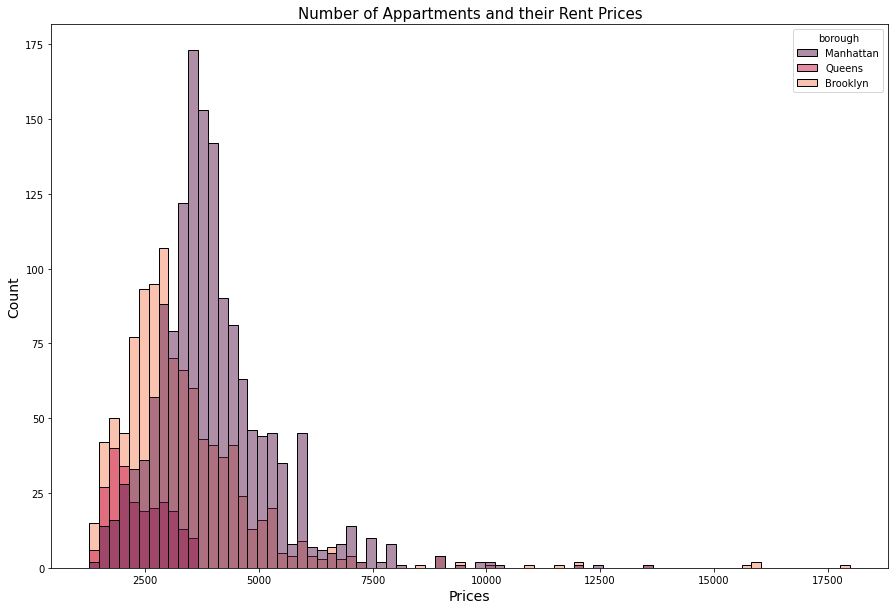

In [16]:
plt.figure(figsize=(15,10))
sns.histplot(data=nyc_flats, x='rent', hue='borough', palette='rocket')
plt.title('Number of Appartments and their Rent Prices',  fontsize=15)
plt.xlabel('Prices', fontsize=14)
plt.ylabel('Count', fontsize=14)

Summary: looks like data is clean, but there is not enough data in Queens, compared to other boroughs, so to predict prices better we'll have to eventually create separate models for each borough.

### Create MLR Models 

Multiple Linear Regression uses two or more independent variables to predict the values of the dependent variable. 

#### Model with 2 independent features
We are going to start without dividing dataset by boroughs, but with only 2 independent, but significant from potential buyer/seller point of view features: `size_sqft` and `building_age_yrs`. By doing so we will try to uncover potential rent's dependency from the size of an apartment and the age of the building where this apartment is located.  

In [17]:
# Instantiate model
model1 = LinearRegression()

# Assign features
X = nyc_flats[['size_sqft', 'building_age_yrs']]
y = nyc_flats[['rent']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=None)

# Train the model
model1.fit(X_train, y_train)

# Get accuracy & coeficiency
print("Accuracy of training data: ", model1.score(X_train, y_train).round(2)*100, '%')
print('Coeficiency of training data (app. size):', model1.coef_[0][0].round(2))
print('Coeficiency of training data (building\'s age):', model1.coef_[0][1].round(2))

# Get accuracy & coeficiency
print("Accuracy of testing data: ", model1.score(X_test, y_test).round(2)*100, '%')
print('Coeficiency of testing data (app. size):', model1.coef_[0][0].round(2))
print('Coeficiency of testing data (building\'s age):', model1.coef_[0][1].round(2))

Accuracy of training data:  39.0 %
Coeficiency of training data (app. size): 3.24
Coeficiency of training data (building's age): -7.58
Accuracy of testing data:  32.0 %
Coeficiency of testing data (app. size): 3.24
Coeficiency of testing data (building's age): -7.58


Result: 
- Accuracy is too low, though we have a clean dataset. It's hard to say what exactly is causing it at this point, maybe it's drastically unequal numbers of 1ns and zeros in each columns that makes model perplexed. 

- Coefficients are most helpful in determining which independent variable carries more weight. From the results above we can see that the age of building impacts cost very significantly with negative relationship, meaning when the age of the building increases the cost decreases. The size of an apartment has positive relationship, meaning the bigger the apartment the higher the cost. 

In [18]:
nyc_flats.value_counts(['borough', 'bedrooms'] )

borough    bedrooms
Manhattan  1.0         1476
Brooklyn   2.0          344
           1.0          340
Queens     1.0          232
Brooklyn   3.0          140
           0.0          135
           4.0           22
           1.5           19
           2.5            7
           0.5            2
           3.5            2
           4.5            1
           5.0            1
dtype: int64

So the accuracy may be low because only Brooklyn has a variety in the number of bedrooms. So we probably need to filter the `df` by boroughs before feeding them to individual models, as well as select parameters that matter for each borough. Though in real life parameters like "the number of bedrooms" obviously matters when one considers the price, here on the opposite: when we have info only about 1-bedroom apartments in 2 out of 3 available boroughs it only perplexes model, when it tries to predict the price.

In [19]:
nyc_flats.value_counts(['borough', 'size_sqft'])[:30]

borough    size_sqft
Brooklyn   1000         78
Manhattan  700          72
           600          71
           650          61
Brooklyn   900          60
Manhattan  800          59
Brooklyn   800          55
Manhattan  750          51
Brooklyn   750          40
           700          36
Manhattan  850          32
           550          30
Brooklyn   850          27
Manhattan  900          26
Brooklyn   650          24
Queens     700          23
Brooklyn   950          23
Manhattan  500          22
Brooklyn   1200         22
           1100         21
           1500         19
           500          17
Manhattan  1000         17
           670          14
           1100         12
Brooklyn   550          12
Manhattan  775          11
Brooklyn   675          10
           1300         10
Manhattan  730          10
dtype: int64

"Square meters" parameter's results looks more diverse, but there are simply not enough data about Queens.

#### Visualize Results in 2D and 3D

Now we are going to visualise results in a form of scatterplot of existing values and the line of linear regression. That will show us how much our line is accurate visually. Ideally line should go right in the middle of results's dots pack. 

In [194]:
def act_vs_pred(model, X, y, subplot_titles):
    # Display subplots
    fig = make_subplots(rows=len(X), cols=1, subplot_titles=subplot_titles)

    for i in range(len(X)):
        # Add scatter markers
        fig.append_trace(
            go.Scatter(x=model.predict(X[i])[:,0], y=y[i]['rent'], opacity=.7, mode='markers'),
            row=i+1, col=1
        )
        # Add line
        fig.add_shape(type='line', x0=0, y0=0, x1=14000, y1=14000, line=dict(color='#663399'), row=i+1, col=1)
    # Additional plot set up
    fig.update_layout(width=800, height=800, title = 'Actual Rent Prices vs Predicted', showlegend=False)
    fig.update_yaxes(title_text='Actual')
    fig.update_xaxes(title_text='Predicted')

    return fig.show()

In [195]:
act_vs_pred(model1, X=[X_train, X_test], y=[y_train, y_test], subplot_titles=['Training Data', 'Testing Data'])

In [22]:
def ratio_3D(model, X, y, marker_colors, surface_colors, datatype):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig = plt.figure(figsize=(20,15))

    for i in range(len(X)):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')

        ax.scatter(X[i][['size_sqft']], X[i][['building_age_yrs']], y[i], c=marker_colors[i], marker='o', alpha=0.2)

        ax.plot_surface(
            np.array([[0,0], [4500, 4500]]), 
            np.array([[0, 170], [0, 170]]), 
            model.predict(
                pd.DataFrame(np.array([[0, 0, 4500, 4500], [0, 170, 0, 170]]).T,
                columns=['size_sqft', 'building_age_yrs'])).reshape((2,2)), 
                alpha=.5, 
                color=surface_colors[i])

        ax.set_xlabel('Size (ft$^2$)', fontsize=14, labelpad = 15)
        ax.set_ylabel('Age (Years)', fontsize=14, labelpad = 15)
        ax.set_zlabel('Rent($)', fontsize=14, labelpad = 15)
        ax.set_title(f'Ratio for {datatype[i]} Data', fontsize=14)

    return plt.show()

<Figure size 576x288 with 0 Axes>

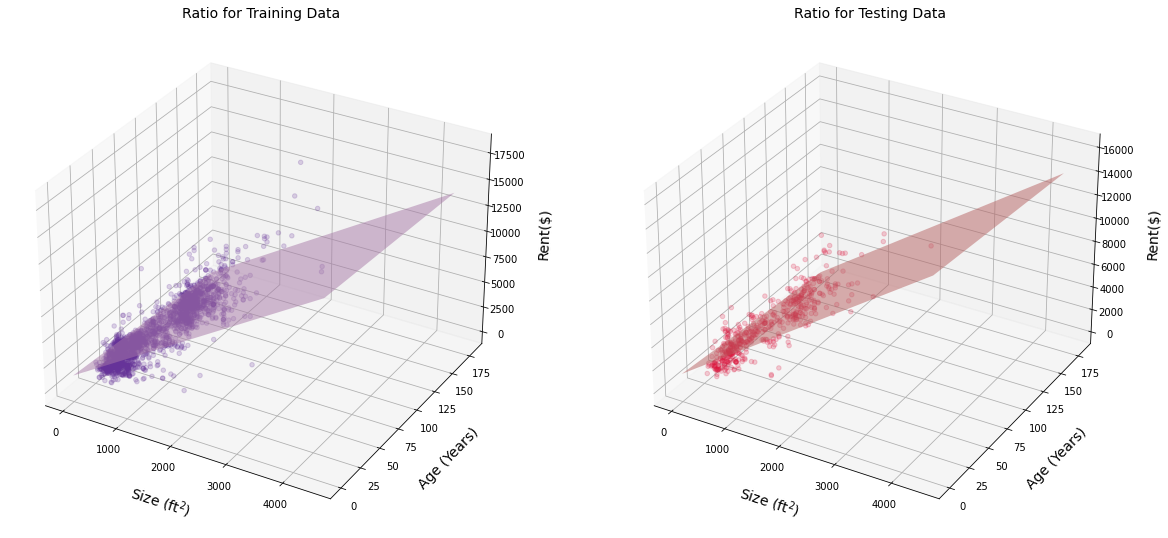

In [23]:
ratio_3D(
    model1, 
    X=[X_train, X_test], 
    y=[y_train, y_test], 
    marker_colors=['RebeccaPurple', 'Crimson'], 
    surface_colors=['Plum', 'LightCoral'],
    datatype = ['Training', 'Testing']
    )

#### Models with many independent features
##### Model for Brooklin

In [160]:
def create_model(borough_name, X_features, random_state=None):
    # Assign features 
    X = nyc_flats[nyc_flats.borough == borough_name][X_features]
        
    y = nyc_flats[nyc_flats.borough == borough_name][['rent']]

    # Instantiate model for Brooklin only
    model = LinearRegression()
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=random_state)
    # Train model
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

model_b, X_train_b, X_test_b, y_train_b, y_test_b = create_model(
    borough_name = 'Brooklyn', 
    X_features= [
        'size_sqft', 
        'building_age_yrs', 
        'bedrooms', 
        'bathrooms', 
        'min_to_subway', 
        'floor', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher', 
        'has_patio', 
        'has_doorman', 
        'has_gym'
    ], 
    random_state = None)


def get_acc_coef(model, X_test, y_test, X_features):
    # Get accuracy & coeficiency
    print("Accuracy: ", model.score(X_test, y_test).round(2)*100, '%')

    features = X_features

    print("Coefficients:")
    for i in range(len(features)):
        print('-', features[i], model_b.coef_[0][i].round(2))
    return

get_acc_coef(
    model_b, 
    X_test_b, 
    y_test_b, 
    X_features=[
        'size_sqft', 
        'building_age_yrs', 
        'bedrooms', 
        'bathrooms', 
        'min_to_subway', 
        'floor', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher', 
        'has_patio', 
        'has_doorman', 
        'has_gym'
    ])


Accuracy:  61.0 %
Coefficients:
- size_sqft 2.5
- building_age_yrs -3.62
- bedrooms -96.81
- bathrooms 865.02
- min_to_subway -40.82
- floor 14.82
- has_roofdeck 260.44
- has_elevator 30.77
- has_dishwasher 75.49
- has_patio 265.58
- has_doorman -254.45
- has_gym 424.4


##### Model for Manhattan

Before proceeding with creation of model for Manhattan I've checked some other columns' values to see if there were similar situations as with `bedrooms` and I have found that something similar, although not so prominent happening within `bathrooms` column, so we'll try to omit `bedrooms` and `bathrooms` for Manhattan model. 

In [161]:
nyc_flats.value_counts(['borough', 'bathrooms'])

borough    bathrooms
Manhattan  1            1415
Brooklyn   1             779
Queens     1             232
Brooklyn   2             213
Manhattan  2              55
Brooklyn   3              14
           0               6
Manhattan  0               6
Brooklyn   4               1
dtype: int64

In [179]:
# Create model for Manhattan
model_m, X_train_m, X_test_m, y_train_m, y_test_m = create_model(
    borough_name = 'Manhattan',
    X_features= [
        'size_sqft', 
        'building_age_yrs', 
        # 'bedrooms', 
        # 'bathrooms', 
        'min_to_subway', 
        'floor', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher', 
        'has_patio', 
        'has_doorman', 
        'has_gym'
    ], 
    random_state = None)

# Get accuracy and coefficiency for Manhattan model
get_acc_coef(
    model_m, 
    X_test_m, 
    y_test_m,
    X_features=[
        'size_sqft', 
        'building_age_yrs', 
        # 'bedrooms', 
        # 'bathrooms', 
        'min_to_subway', 
        'floor', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher', 
        'has_patio', 
        'has_doorman', 
        'has_gym'
    ])

Accuracy:  64.0 %
Coefficients:
- size_sqft 2.5
- building_age_yrs -3.62
- min_to_subway -96.81
- floor 865.02
- has_roofdeck -40.82
- has_elevator 14.82
- has_dishwasher 260.44
- has_patio 30.77
- has_doorman 75.49
- has_gym 265.58


##### Model for Queens

In [184]:
# Create model for Manhattan
model_q, X_train_q, X_test_q, y_train_q, y_test_q = create_model(
    borough_name = 'Queens',
    X_features= [
        'size_sqft', 
        'building_age_yrs', 
        # 'bedrooms', 
        # 'bathrooms', 
        'min_to_subway', 
        'floor', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher', 
        'has_patio', 
        'has_doorman', 
        'has_gym'
    ], 
    random_state = None)

# Get accuracy and coefficiency for Manhattan model
get_acc_coef(
    model_q, 
    X_test_q, 
    y_test_q,
    X_features=[
        'size_sqft', 
        'building_age_yrs', 
        # 'bedrooms', 
        # 'bathrooms', 
        'min_to_subway', 
        'floor', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher', 
        'has_patio', 
        'has_doorman', 
        'has_gym'
    ])

Accuracy:  65.0 %
Coefficients:
- size_sqft 2.5
- building_age_yrs -3.62
- min_to_subway -96.81
- floor 865.02
- has_roofdeck -40.82
- has_elevator 14.82
- has_dishwasher 260.44
- has_patio 30.77
- has_doorman 75.49
- has_gym 265.58


#### Visualize Actual vs Predicted for each Borough

In [192]:
def act_vs_pred(models, X_train, y_train):
    # Display subplots
    fig = make_subplots(rows=len(models), cols=1, subplot_titles=('Brooklyn', 'Manhattan', 'Queens'))

    for i in range(len(models)):
        # Add scatter markers
        fig.append_trace(
            go.Scatter(x=models[i].predict(X_train[i])[:,0], y=y_train[i]['rent'], opacity=.7, mode='markers'),
            row=i+1, col=1
        )
        # Add line
        fig.add_shape(type='line', x0=0, y0=0, x1=14000, y1=14000, line=dict(color='#663399'), row=i+1, col=1)
    # Additional plot set up
    fig.update_layout(width=800, height=800, title = 'Actual Rent Prices vs Predicted', showlegend=False)
    fig.update_yaxes(title_text='Actual')
    fig.update_xaxes(title_text='Predicted')

    return fig.show()

In [193]:
act_vs_pred(
    models=[model_b, model_m, model_q], 
    X_train=[X_train_b, X_train_m, X_train_q], 
    y_train=[y_train_b, y_train_m, y_train_q])

Summary: 
- Our accuracy has roughly doubled on test data since we've split our dataset by borough and excluded `bedrooms` and `bathrooms` since their data is prone to uniformity, which is bad in this situation. 
- But if we look at graphs "Actual Price vs Predicted" the picture is not bad - data points tend to be close to the line on which actual and predicted prices are coinciding.

### Simulation of Extrinsic Testing

We are going to feed to each borough's model some data and see what price we would be able to get out of them.  